# NLP-LAB Exercise 02 by Jonas Weinz (2571421)
## links:

* Article: https://miguelmalvarez.com/2017/03/23/how-can-machine-learning-and-ai-help-solving-the-fake-news-problem/
    * corresponding code: https://github.com/kjam/random_hackery/blob/master/Attempting%20to%20detect%20fake%20news.ipynb

* Tutorial on Datacamp: https://www.datacamp.com/community/tutorials/scikit-learn-fake-news

* liar dataset paper: https://www.cs.ucsb.edu/~william/papers/acl2017.pdf
    * dataset: https://www.cs.ucsb.edu/~william/data/liar_dataset.zip

## Dependencies for this Notebook:
* library [rdflib](https://github.com/RDFLib/rdflib)
    * install: `pip3 install rdflib`


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import itertools
import sklearn.utils as sku
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
from pprint import pprint as pp
from IPython.display import display, Markdown, Latex
import collections
import traceback
import os

## Tools used later

In [3]:
def plot_confusion_matrix(cm, classes,
                          title,
                          normalize=False,
                          cmap=plt.cm.Blues):
    fig_1, ax_1 = plt.subplots()
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix for: ' + title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def test_classifier(labels, title, Xt, yt, clf):
    pred = clf.predict(Xt)
    score = metrics.accuracy_score(yt, pred)
    pp("score: " + str(score))
    cm = metrics.confusion_matrix(yt, pred, labels=labels)
    plot_confusion_matrix(cm, classes=labels, title=title)

## Generate/Download Datasets we are working on

* running bash script to download all needed data and store it into the `data` subfolder

In [5]:
%%bash
./Task_2_gen_data.sh

checking whether unzip is installed
UnZip 6.00 of 20 April 2009, by Debian. Original by Info-ZIP.

Latest sources and executables are at ftp://ftp.info-zip.org/pub/infozip/ ;
see ftp://ftp.info-zip.org/pub/infozip/UnZip.html for other sites.

Compiled with gcc 6.3.0 20170415 for Unix (Linux ELF).

UnZip special compilation options:
        ACORN_FTYPE_NFS
        COPYRIGHT_CLEAN (PKZIP 0.9x unreducing method not supported)
        SET_DIR_ATTRIB
        SYMLINKS (symbolic links supported, if RTL and file system permit)
        TIMESTAMP
        UNIXBACKUP
        USE_EF_UT_TIME
        USE_UNSHRINK (PKZIP/Zip 1.x unshrinking method supported)
        USE_DEFLATE64 (PKZIP 4.x Deflate64(tm) supported)
        UNICODE_SUPPORT [wide-chars, char coding: UTF-8] (handle UTF-8 paths)
        LARGE_FILE_SUPPORT (large files over 2 GiB supported)
        ZIP64_SUPPORT (archives using Zip64 for large files supported)
        USE_BZIP2 (PKZIP 4.6+, using bzip2 lib version 1.0.6, 6-Sept-2010)
     

----
## configuration 1

In [6]:
df_1 = pd.read_csv('data/fake_or_real_news.csv').set_index('Unnamed: 0')

* display first 10 entries

In [7]:
display(df_1.shape)
display(df_1[:10])

(6335, 3)

title  \
Unnamed: 0                                                      
8476                             You Can Smell Hillary’s Fear   
10294       Watch The Exact Moment Paul Ryan Committed Pol...   
3608              Kerry to go to Paris in gesture of sympathy   
10142       Bernie supporters on Twitter erupt in anger ag...   
875          The Battle of New York: Why This Primary Matters   
6903                                              Tehran, USA   
7341        Girl Horrified At What She Watches Boyfriend D...   
95                          ‘Britain’s Schindler’ Dies at 106   
4869        Fact check: Trump and Clinton at the 'commande...   
2909        Iran reportedly makes new push for uranium con...   

                                                         text label  
Unnamed: 0                                                           
8476        Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
10294       Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
3608        U.S. Secretary of State John F. Kerry said Mon...  REAL  
10142       — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
875         It's primary day in New York and front-runners...  REAL  
6903          \nI’m not an immigrant, but my grandparents ...  FAKE  
7341        Share This Baylee Luciani (left), Screenshot o...  FAKE  
95          A Czech stockbroker who saved more than 650 Je...  REAL  
4869        Hillary Clinton and Donald Trump made some ina...  REAL  
2909        Iranian negotiators reportedly have made a las...  REAL

* create test dataset

In [8]:
def create_training_and_test_set(dset, cutoff=0.7):
    shuffled = sku.shuffle(dset) # shuffle dataset
    y = shuffled.label
    shuffled = shuffled.drop('label', axis=1)['text']
    size = int(cutoff * shuffled.shape[0])
    return shuffled[:size], y[:size], shuffled[size:], y[size:]
    

In [9]:
X1,y1, Xt1,yt1 = create_training_and_test_set(df_1)

In [10]:
count_vectorizer_1 = CountVectorizer(stop_words='english')
count_train_1 = count_vectorizer_1.fit_transform(X1)
count_test_1 = count_vectorizer_1.transform(Xt1)

In [11]:
tfidf_vectorizer_1 = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train_1 = tfidf_vectorizer_1.fit_transform(X1)
tfidf_test_1 = tfidf_vectorizer_1.transform(Xt1)

In [12]:
#display(count_vectorizer.get_feature_names()[0:10])
#display(count_vectorizer.get_feature_names()[-10:])


In [13]:
#display(tfidf_vectorizer.get_feature_names()[:10])
#display(tfidf_vectorizer.get_feature_names()[-10:])

In [14]:
#count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
#tfidf_df = pd.DataFrame(count_train.A, columns=tfidf_vectorizer.get_feature_names())
#diff = set(count_df.columns) - set(tfidf_df.columns)
#pp(count_df.equals(tfidf_df))

'score: 0.8395581273014203'
Confusion matrix, without normalization


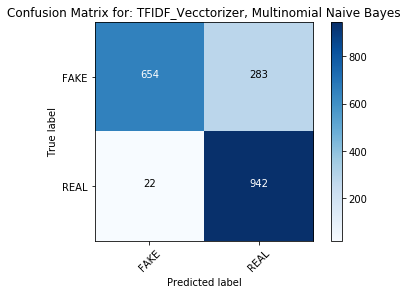

In [16]:
clf = MultinomialNB()
clf.fit(tfidf_train_1, y1)
pred = clf.predict(tfidf_test_1)
score = metrics.accuracy_score(yt1, pred)
pp("score: " + str(score))
cm = metrics.confusion_matrix(yt1, pred, labels=["FAKE", "REAL"])
plot_confusion_matrix(cm, classes=["FAKE", "REAL"], title= "TFIDF_Vecctorizer, Multinomial Naive Bayes")

'score: 0.8869016307206733'
Confusion matrix, without normalization


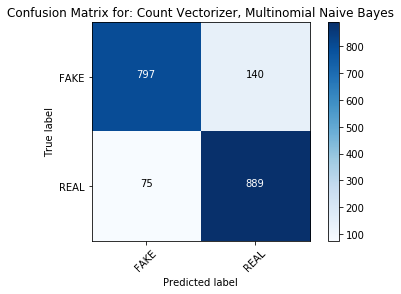

In [17]:
clf_a = MultinomialNB()
clf_a.fit(count_train_1, y1)
test_classifier(labels=["FAKE","REAL"], title="Count Vectorizer, Multinomial Naive Bayes", Xt=count_test_1,yt=yt1, clf=clf_a)

* comparing to PassiveAggresiveClassifier

/home/jonas/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


accuracy:   0.933
Confusion matrix, without normalization


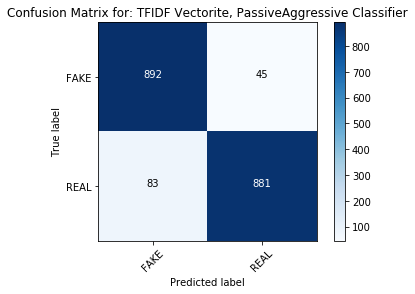

In [18]:
linear_clf = PassiveAggressiveClassifier(n_iter=50)

linear_clf.fit(tfidf_train_1, y1)
pred = linear_clf.predict(tfidf_test_1)
score = metrics.accuracy_score(yt1, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(yt1, pred, labels=['FAKE', 'REAL'])
plot_confusion_matrix(cm, classes=['FAKE', 'REAL'], title= "TFIDF Vectorite, PassiveAggressive Classifier")

In [19]:
#clf = MultinomialNB(alpha=0.1)
#last_score = 0
#for alpha in np.arange(0,1,.1):
#    nb_classifier = MultinomialNB(alpha=alpha)
#    nb_classifier.fit(tfidf_train_1, y1)
#    pred = nb_classifier.predict(tfidf_test_1)
#    score = metrics.accuracy_score(yt1, pred)
#    if score > last_score:
#        clf = nb_classifier
#    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))

* try to get most important features

In [20]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    """
    See: https://stackoverflow.com/a/26980472
    
    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show. (Note: current implementation merely prints and does not 
    return top classes.)
    """

    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
    
    l = []
    
    for coef, feat in topn_class1:
        l.append((class_labels[0], coef, feat))

    display(l)

    for coef, feat in reversed(topn_class2):
        l.append((class_labels[1], coef, feat))
    
    display(l)


most_informative_feature_for_binary_classification(tfidf_vectorizer_1, linear_clf, n=30)



[('FAKE', -5.09148236435967, '2016'),
 ('FAKE', -4.711308849297324, 'october'),
 ('FAKE', -3.7170090859114935, 'hillary'),
 ('FAKE', -2.9629451875503636, 'election'),
 ('FAKE', -2.9532733338247192, 'article'),
 ('FAKE', -2.5913388599541607, 'share'),
 ('FAKE', -2.5113445616853625, 'wikileaks'),
 ('FAKE', -2.4154047960961784, 'source'),
 ('FAKE', -2.3661872358294853, 'podesta'),
 ('FAKE', -2.2727185001128776, 'november'),
 ('FAKE', -2.204821774138259, 'advertisement'),
 ('FAKE', -2.1570514850733904, 'corporate'),
 ('FAKE', -2.1316069320786863, 'kelly'),
 ('FAKE', -2.100506081374764, 'establishment'),
 ('FAKE', -2.063743396467079, 'email'),
 ('FAKE', -2.047274951558231, 'snip'),
 ('FAKE', -2.0443830149677353, 'print'),
 ('FAKE', -1.9775756559762447, 'mosul'),
 ('FAKE', -1.8875909018863903, 'oct'),
 ('FAKE', -1.8829089357171849, 'war'),
 ('FAKE', -1.844565871218784, 'corruption'),
 ('FAKE', -1.8422478599882626, '26'),
 ('FAKE', -1.8386058868939217, 'uk'),
 ('FAKE', -1.8285844309040236, 'p

[('FAKE', -5.09148236435967, '2016'),
 ('FAKE', -4.711308849297324, 'october'),
 ('FAKE', -3.7170090859114935, 'hillary'),
 ('FAKE', -2.9629451875503636, 'election'),
 ('FAKE', -2.9532733338247192, 'article'),
 ('FAKE', -2.5913388599541607, 'share'),
 ('FAKE', -2.5113445616853625, 'wikileaks'),
 ('FAKE', -2.4154047960961784, 'source'),
 ('FAKE', -2.3661872358294853, 'podesta'),
 ('FAKE', -2.2727185001128776, 'november'),
 ('FAKE', -2.204821774138259, 'advertisement'),
 ('FAKE', -2.1570514850733904, 'corporate'),
 ('FAKE', -2.1316069320786863, 'kelly'),
 ('FAKE', -2.100506081374764, 'establishment'),
 ('FAKE', -2.063743396467079, 'email'),
 ('FAKE', -2.047274951558231, 'snip'),
 ('FAKE', -2.0443830149677353, 'print'),
 ('FAKE', -1.9775756559762447, 'mosul'),
 ('FAKE', -1.8875909018863903, 'oct'),
 ('FAKE', -1.8829089357171849, 'war'),
 ('FAKE', -1.844565871218784, 'corruption'),
 ('FAKE', -1.8422478599882626, '26'),
 ('FAKE', -1.8386058868939217, 'uk'),
 ('FAKE', -1.8285844309040236, 'p

----
## configuration 2

* read data

In [21]:
names = [
    "id",
    "label",
    "statement",
    "subjects",
    "speaker",
    "job",
    "state",
    "party",
    "#barely_true",
    "#false",
    "#half_true",
    "#mostly_true",
    "#pants_on_fire",
    "context"
]

df_2_train = pd.read_csv("data/train.tsv", delimiter='\t', names=names)
df_2_test = pd.read_csv("data/test.tsv", delimiter='\t', names=names)

# use only 'False' and 'True' statements

df_2_train = df_2_train[df_2_train['label'].isin(["false","true"])]
df_2_test = df_2_test[df_2_test['label'].isin(["false","true"])]

display(Markdown("----\n#### Train Data:"))
display(df_2_train.head())
display(Markdown("----\n#### Test Data:"))
display(df_2_test.head())

----
#### Train Data:

id  label                                          statement  \
0    2635.json  false  Says the Annies List political group supports ...   
3    1123.json  false  Health care reform legislation is likely to ma...   
5   12465.json   true  The Chicago Bears have had more starting quart...   
12   5947.json  false  When Mitt Romney was governor of Massachusetts...   
16    620.json   true  McCain opposed a requirement that the governme...   

                subjects       speaker                         job  \
0               abortion  dwayne-bohac        State representative   
3            health-care  blog-posting                         NaN   
5              education     robin-vos  Wisconsin Assembly speaker   
12  history,state-budget   mitt-romney             Former governor   
16        federal-budget  barack-obama                   President   

            state       party  #barely_true  #false  #half_true  #mostly_true  \
0           Texas  republican           0.0     1.0         0.0           0.0   
3             NaN        none           7.0    19.0         3.0           5.0   
5       Wisconsin  republican           0.0     3.0         2.0           5.0   
12  Massachusetts  republican          34.0    32.0        58.0          33.0   
16       Illinois    democrat          70.0    71.0       160.0         163.0   

    #pants_on_fire                     context  
0              0.0                    a mailer  
3             44.0              a news release  
5              1.0   a an online opinion-piece  
12            19.0  an interview with CBN News  
16             9.0                  a radio ad

----
#### Test Data:

id  label                                          statement  \
0  11972.json   true  Building a wall on the U.S.-Mexico border will...   
1  11685.json  false  Wisconsin is on pace to double the number of l...   
2  11096.json  false  Says John McCain has done nothing to help the ...   
5   5962.json   true  Over the past five years the federal governmen...   
6   7070.json   true  Says that Tennessee law requires that schools ...   

                                          subjects                   speaker  \
0                                      immigration                rick-perry   
1                                             jobs         katrina-shankland   
2                  military,veterans,voting-record              donald-trump   
5               federal-budget,pensions,retirement           brendan-doherty   
6  county-budget,county-government,education,taxes  stand-children-tennessee   

                                          job         state       party  \
0                                    Governor         Texas  republican   
1                        State representative     Wisconsin    democrat   
2                             President-Elect      New York  republican   
5                                         NaN  Rhode Island  republican   
6  Child and education advocacy organization.     Tennessee        none   

   #barely_true  #false  #half_true  #mostly_true  #pants_on_fire  \
0            30      30          42            23              18   
1             2       1           0             0               0   
2            63     114          51            37              61   
5             1       2           1             1               0   
6             0       0           0             0               0   

                        context  
0               Radio interview  
1             a news conference  
2  comments on ABC's This Week.  
5            a campaign website  
6        in a post on Facebook.

#### tdidf vectorizer on new dataset


In [22]:
X2 = df_2_train['statement']
y2 = df_2_train['label']
Xt2 = df_2_test['statement']
yt2 = df_2_test['label']



In [23]:
count_vectorizer_2 = TfidfVectorizer(stop_words='english', max_df=0.7)
count_train_2 = count_vectorizer_2.fit_transform(X2)
count_test_2 = count_vectorizer_2.transform(Xt2)

In [24]:
clf_b = MultinomialNB()
clf_b.fit(count_train_2, y2)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

'score: 0.6192560175054704'
Confusion matrix, without normalization


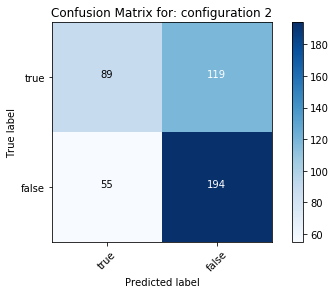

In [25]:
test_classifier(labels=["true", "false"], title="configuration 2", Xt=count_test_2, yt=yt2, clf=clf_b)

----
## configuration 3

'score: 0.45295404814004375'
Confusion matrix, without normalization


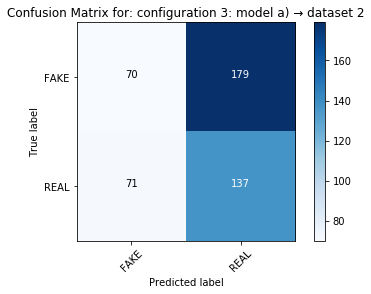

In [26]:
yt2_c3 = yt2.copy()
yt2_c3[yt2_c3 == "true"] = "REAL"
yt2_c3[yt2_c3 == "false"] = "FAKE"

test_classifier(labels=["FAKE", "REAL"], 
                title="configuration 3: model a) → dataset 2",
                Xt=count_vectorizer_1.transform(Xt2),
                yt=yt2_c3, clf=clf_a)

'score: 0.4807995791688585'
Confusion matrix, without normalization


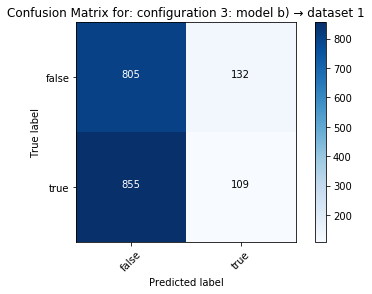

In [27]:
yt1_c3 = yt1.copy()
yt1_c3[yt1_c3 == "REAL"] = "true"
yt1_c3[yt1_c3 == "FAKE"] = "false"

test_classifier(labels=["false", "true"], 
                title="configuration 3: model b) → dataset 1",
                Xt=count_vectorizer_2.transform(Xt1),
                yt=yt1_c3, clf=clf_b)

----
## configuration 4)